<a href="https://colab.research.google.com/github/aricem/BusinessForecasting/blob/master/CPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This study is prepared as Term Project for I.T.U. EMBA Programme Business Forecasting Lecture. The aim of this study is to determine the most appropriate forecasting model for Consumer Price Index of Turkey.

**D. Cem Selman**

**408181053**

# Preparation

This study is prepared in Colaboratory environment of Google. [Colaboratory](http://colab.research.google.com/) is a Google research project created to help disseminate machine learning education and research. It's a Jupyter notebook environment that requires no setup to use and runs entirely in the cloud.

Raw data is in Google Drive. So, you can mount your Google Drive files by running the following code snippet. The cell will return with a link and you need to go to the link to retrieve the authorization code.

In [493]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Disable warnings for clean outputs.

In [0]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

Now, create some methods that are not avaiable in *sklearn.metrics* package

In [0]:
from math import sqrt
import numpy as np

def mean_error(y_true, y_pred):
  '''returns mean errors (actual vs model)'''
  return np.mean(y_true - y_pred)

def mean_percentage_error(y_true, y_pred):
  '''returns mean percentage errors (actual vs model)'''
  return np.mean((y_true - y_pred) / y_true)

def mean_absolute_percentage_error(y_true, y_pred):
  '''returns mean absolute percentage errors (actual vs model)'''
  return np.mean(np.abs((y_true - y_pred) / y_true))

def sse(y_true, y_pred):
  '''returns sum of squared errors (actual vs model)'''
  return np.sum((y_true - y_pred) ** 2)

def sst(y_true, y_pred):
  '''returns total sum of squared errors (actual vs avg(actual))'''
  y_avg = np.mean(y_true)
  return np.sum((y_true - y_avg) ** 2)

# Dataset

Historical CPI dataset is downloaded from [TUIK](). It is simplified and converted to csv file for further analysis.

This dataset describes the monthly annual rate of change of CPI over a 16 year period, as of Feb 1st, 2003.

Below is a sample of the first 5 rows of data, including the header row.

In [496]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

sh = gc.open('CPI')
worksheet = sh.worksheet("RawData") # By title
#worksheet = sh.sheet1 # By sheet order
#worksheet = sh.get_worksheet(0) # Select worksheet by index

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df.drop(df.index[:1], inplace=True)
#Convert data types
df['Date']= pd.to_datetime(df['Date'], errors='coerce')
df['CPI'] = pd.to_numeric(df['CPI'], errors='coerce')
df['M1'] = pd.to_numeric(df['M1'], errors='coerce')
df['M3'] = pd.to_numeric(df['M3'], errors='coerce')
df['USDTRY'] = pd.to_numeric(df['USDTRY'], errors='coerce')
df['QGDP'] = pd.to_numeric(df['QGDP'], errors='coerce')
df.info()
#Print head
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 1 to 195
Data columns (total 6 columns):
Date      195 non-null datetime64[ns]
CPI       195 non-null float64
M1        191 non-null float64
M3        191 non-null float64
USDTRY    195 non-null float64
QGDP      64 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.7 KB


,Date,CPI,M1,M3,USDTRY,QGDP
1,2003-02-01,1.54,7.925606,12.84485,1.5970,NaN
2,2003-03-01,1.96,8.047686,12.94970,1.7155,1.448892
3,2003-04-01,0.99,7.998527,12.86963,1.5657,NaN
4,2003-05-01,0.96,8.018188,12.73953,1.4290,NaN
5,2003-06-01,0.08,8.482919,12.74100,1.4200,0.362453


Below is the plot of the entire dataset.

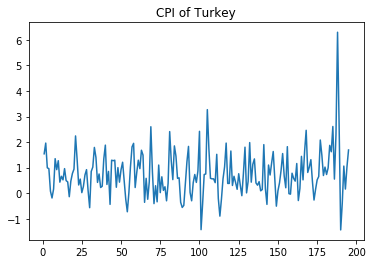

In [497]:
import matplotlib.pyplot as plt
plt.plot(df.index, df.CPI)
plt.title('CPI of Turkey')
plt.show()

# Naïve Models

## Naïve Method 1

Naive model is the most primitive forecasting method. The premise of the naive method is that the expected point is equal to the last observed point:

$$
\hat{y}_{T+h|T} = y_{T}, \tag{1.1}
$$

where;

* $\hat{y}$: prediction
* $y$: actual

The first step is to load the dataset and create a lagged representation.

This snippet creates the dataset and prints the first 5 rows of the new dataset.

We can see that the first row (index 0) will have to be discarded as there was no observation prior to the first observation to use to make the prediction.

From a supervised learning perspective, the *Actual* column is the input variable, or **y_true**, and the *Predict* column is the output variable, or **y_pred**.

In [498]:
#Add new column by applying above model
shift = 1
df_naive1 = pd.concat([df.CPI, df.CPI.shift(shift), df.CPI-df.CPI.shift(shift)], axis=1)
#Rename columns
df_naive1.columns = ['Actual', 'Predict', 'Error']
#Skip first (shift) rows due to NaN forecast value
df_naive1 = df_naive1.iloc[shift:]
#Assign y_true, y_pred and error
y_true = df_naive1['Actual']
y_pred = df_naive1['Predict']
e = df_naive1['Error']
#Print head
df_naive1.head()

,Actual,Predict,Error
2,1.96,1.54,0.42
3,0.99,1.96,-0.97
4,0.96,0.99,-0.03
5,0.08,0.96,-0.88
6,-0.19,0.08,-0.27


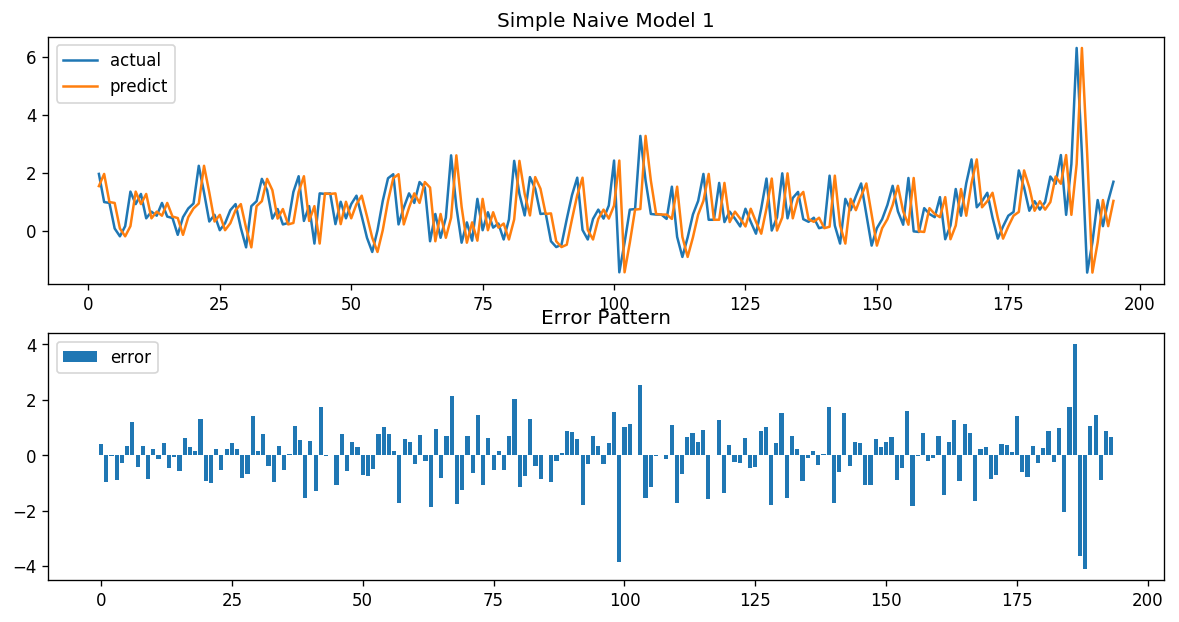

In [499]:
plt.figure(figsize=(12,6), dpi=120)

plt.subplot(2,1,1)
plt.plot(y_true, label="actual")
plt.plot(y_pred, label="predict")
plt.title("Simple Naive Model 1")
plt.legend(loc='best')

plt.subplot(2,1,2)
index = np.arange(len(e))
plt.bar(index, e, label="error")
plt.title("Error Pattern")
plt.legend(loc='best')

plt.show()

In [500]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
sse = sse(y_true, y_pred)
sst = sst(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 1.138
RMSE: 1.067
ME: 0.001
MAE: 0.817
MPE: -0.931
MAPE: 3.740


The next step is to separate the dataset into train and test sets.

We will keep the first 66% of the observations for “training” and the remaining 34% for "evaluation". During the split, we are careful to exclude the first row of data with the NaN value.

No training is required in this case. Each of the train and test sets are then split into the input and output variables.

Observations: 194
Training Observations: 128
Testing Observations: 66


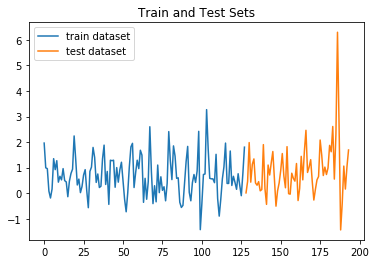

In [501]:
# split into train and test sets
X = df_naive1.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
X_train, y_train= train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]
print("Observations: %d" % len(X))
print("Training Observations: %d" % len(train))
print("Testing Observations: %d" % len(test))

import matplotlib.pyplot as plt
plt.plot(X_train, label="train dataset")
plt.plot([None for i in X_train] + [x for x in X_test], label="test dataset")
plt.title("Train and Test Sets")
plt.legend(loc='best')
plt.show()

No model training or retraining is required, so in essence, we step through the test dataset time step by time step and get predictions.

Once predictions are made for each time step in the training dataset, they are compared to the expected values and a Mean Squared Error (MSE) score is calculated.

In this case, the error is more than 1.598 over the test dataset.

In [502]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
predictions = list()
for x in X_test:
  y_pred = x
  predictions.append(y_pred)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

Test MSE: 1.598
Test RMSE: 1.264


Below plot is to show the training dataset and the diverging predictions from the expected values from the test dataset.

From the plot of the naive model predictions, it is clear that the model is 1-step behind reality. It seems that there is an irregular component for the last periods.

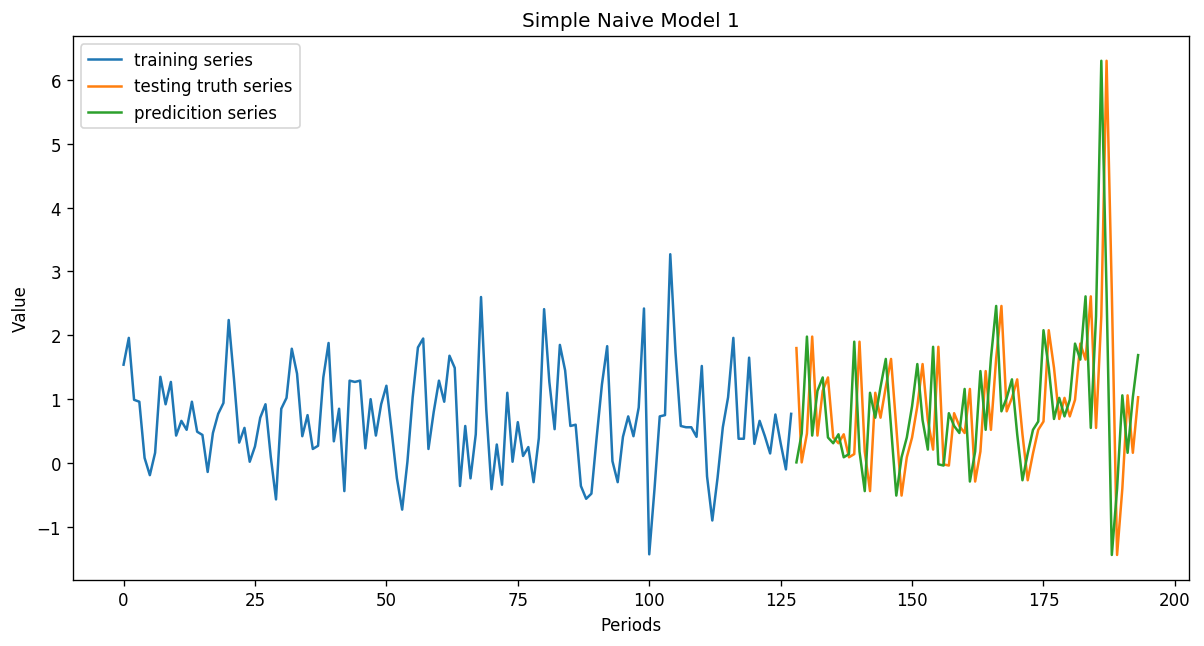

In [503]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=120)
# plot predictions and expected results
plt.plot(y_train, label="training series")
plt.plot([None for i in y_train] + [x for x in y_test], label="testing truth series")
plt.plot([None for i in y_train] + [x for x in predictions], label="predicition series")

plt.title("Simple Naive Model 1")
plt.xlabel("Periods")
plt.ylabel("Value")
plt.legend(loc='best')
plt.show()

We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets. We can still improve our score by adopting different techniques. Now we will look at another technique and try to improve our score.

## Naïve Method 2

$$
\hat{y}_{t+1} = y_t + P (y_t-y_{t-1}) , \tag{1.2}
$$

where;

* $\hat{y}$: prediction
* $y$: actual
* $P$: adjustment coefficient, $0<P<1$

In [504]:
P = 0.1

#Add new column by applying above model
shift = 1
df_naive2 = pd.concat([df.CPI, df.CPI.shift(shift) + P * (df.CPI.shift(shift) - df.CPI.shift(shift * 2)), df.CPI - (df.CPI.shift(shift) + P * (df.CPI.shift(shift) - df.CPI.shift(shift * 2)))], axis=1)
#Skip first (shift * 2) rows due to NaN forecast value
df_naive2 = df_naive2.iloc[shift * 2:]
#Rename columns
df_naive2.columns = ['Actual', 'Predict', 'Error']
y_true = df_naive2['Actual']
y_pred = df_naive2['Predict']
e = df_naive2['Error']
df_naive2.head()

,Actual,Predict,Error
3,0.99,2.002,-1.012
4,0.96,0.893,0.067
5,0.08,0.957,-0.877
6,-0.19,-0.008,-0.182
7,0.16,-0.217,0.377


In [505]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 1.205
RMSE: 1.098
ME: -0.001
MAE: 0.846
MPE: -1.035
MAPE: 4.001


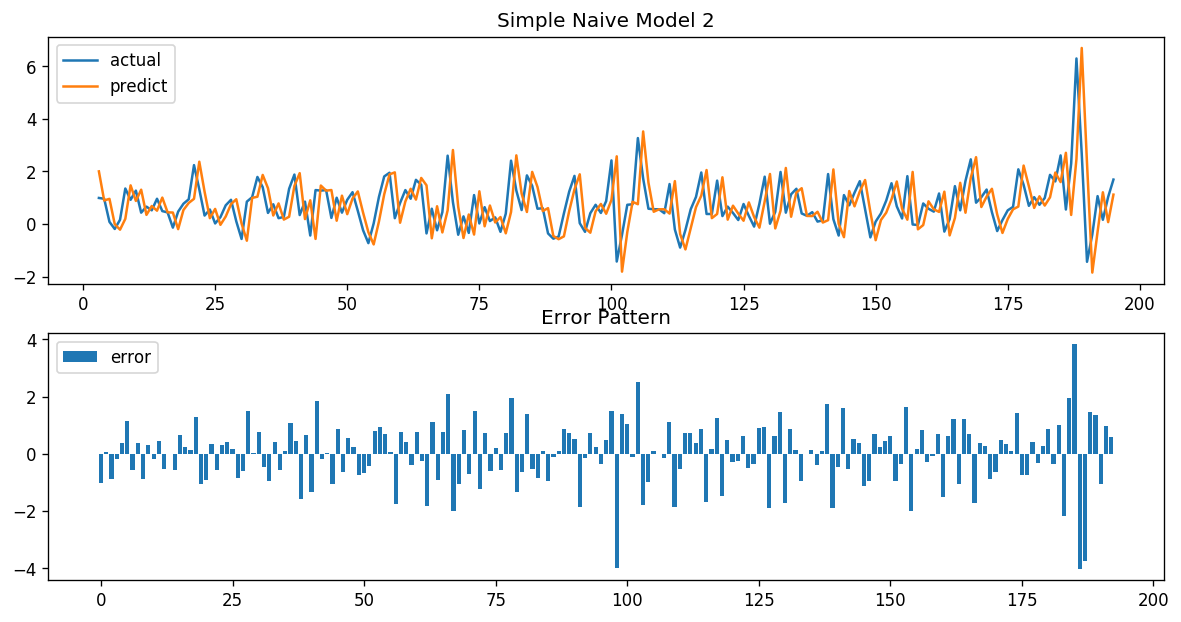

In [506]:
plt.figure(figsize=(12,6), dpi=120)

plt.subplot(2,1,1)
plt.plot(df_naive2['Actual'], label="actual")
plt.plot(df_naive2['Predict'], label="predict")
plt.title("Simple Naive Model 2")
plt.legend(loc='best')

plt.subplot(2,1,2)
index = np.arange(len(df_naive2['Error']))
plt.bar(index, df_naive2['Error'], label="error")
plt.title("Error Pattern")
plt.legend(loc='best')

plt.show()

## Modified Naive Method 1 (Seasonal naïve method 1)

$$
\hat{y}_{T+h|T} = y_{T+h-m(k+1)}
$$

where;

* $m$ is the seasonal period, and $k$ is the integer part of $(h−1)/m$ (i.e., the number of complete years in the forecast period prior to time $T+h$).

In [507]:
#Add new column by applying above model
shift = 12
df_naive1m = pd.concat([df.CPI, df.CPI.shift(shift)], axis=1)
#Skip first (shift) rows due to NaN forecast value
df_naive1m = df_naive1m.iloc[shift:]
#Rename columns
df_naive1m.columns = ['Actual', 'Predict']
y_true = df_naive1m['Actual']
y_pred = df_naive1m['Predict']
#df_naive1m.head()

from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 0.876
RMSE: 0.936
ME: 0.044
MAE: 0.664
MPE: -0.188
MAPE: 2.599


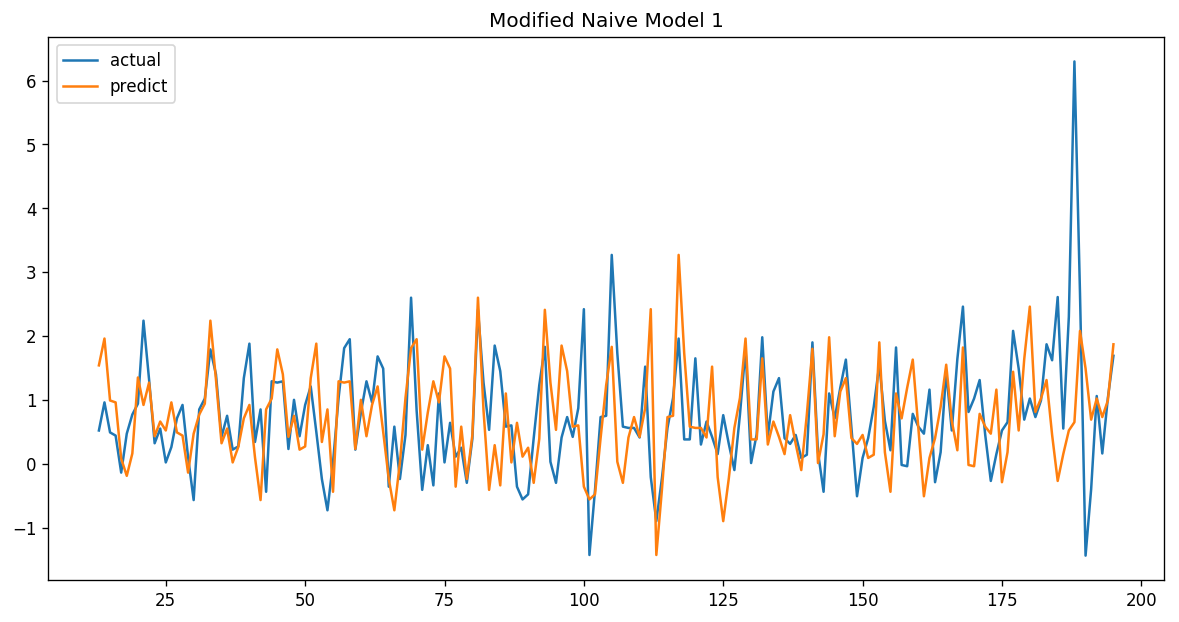

In [508]:
plt.figure(figsize=(12,6), dpi=120)
plt.plot(y_true, label="actual")
plt.plot(y_pred, label="predict")
plt.title("Modified Naive Model 1")
plt.legend(loc='best')
plt.show()

## Modified Naive Method 2 (Seasonal naïve method 2)

In [509]:
P = 0.2250

#Add new column by applying above model
shift = 12
df_naive2m = pd.concat([df.CPI, df.CPI.shift(shift) + P * (df.CPI.shift(shift) - df.CPI.shift(shift * 2))], axis=1)
#Skip first (shift * 2) rows due to NaN forecast value
df_naive2m = df_naive2m.iloc[shift * 2:]
#Rename columns
df_naive2m.columns = ['Actual', 'Predict']
y_true = df_naive2m['Actual']
y_pred = df_naive2m['Predict']
#df_naive2m.head()

from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 1.073
RMSE: 1.036
ME: 0.054
MAE: 0.743
MPE: 0.158
MAPE: 2.800


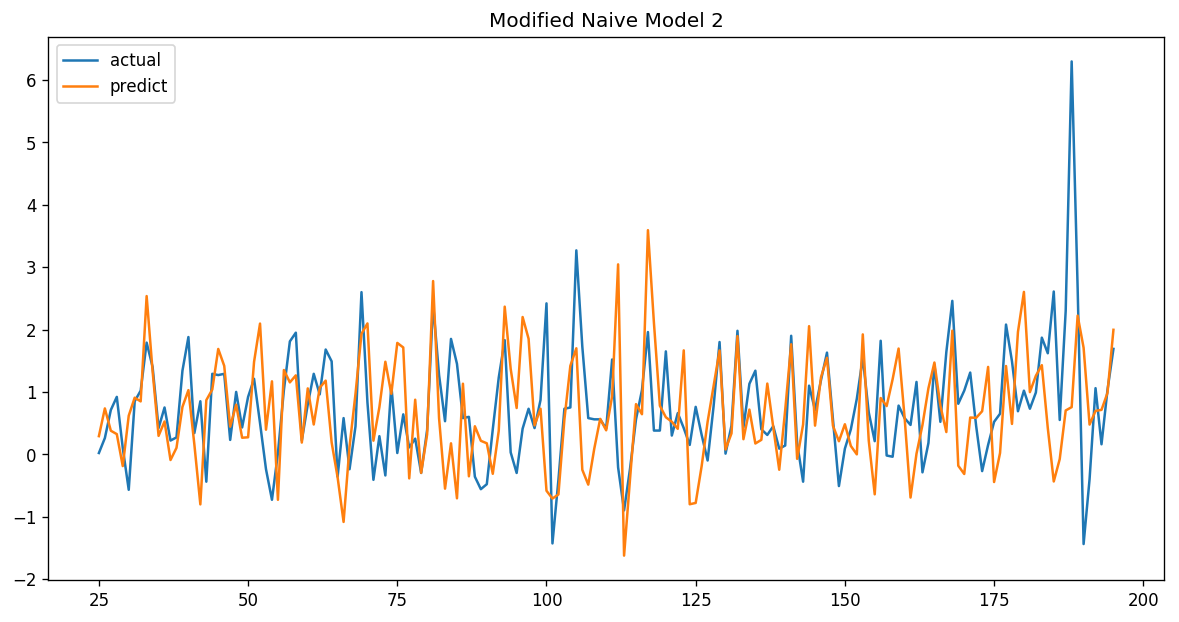

In [510]:
plt.figure(figsize=(12,6), dpi=120)
plt.plot(y_true, label="actual")
plt.plot(y_pred, label="predict")
plt.title("Modified Naive Model 2")
plt.legend(loc='best')
plt.show()

# Smoothing Models

## Moving Average Methods

* For stationary time series
* Not exhibit a simple linear, exponential, or quadratic trend similar
* Series appears to show substantial randomness
* Eliminate randomness with a technique that averages the most recent values
* Intervals can be 3, 5, 7, 9, 10, 12 and so on.
* The choice of the interval for the moving average depends on the length of the underlying cycle or pattern in the original data
* Failure of the moving averages is to predict peaks and troughs

### Simple Average

Simple Average is a forecasting technique which forecasts the expected value equal to the average of all previously observed points.

$$
\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t
$$

* No trend
* No seasonality
* Uses all available data for prediction

In [511]:
predictions = []
for idx, data in enumerate(df.CPI):
  predictions.append(df.CPI.iloc[:idx+1].mean())

df_simple_average = pd.concat([df.CPI, pd.DataFrame(predictions, index=df.index)], axis=1)
#Rename columns
df_simple_average.columns = ['Actual', 'Predict']
y_true = df_simple_average['Actual']
y_pred = df_simple_average['Predict']
df_simple_average.head()

,Actual,Predict
1,1.54,1.540000
2,1.96,1.750000
3,0.99,1.496667
4,0.96,1.362500
5,0.08,1.106000


In [512]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 0.764
RMSE: 0.874
ME: 0.019
MAE: 0.634
MPE: -0.635
MAPE: 2.453


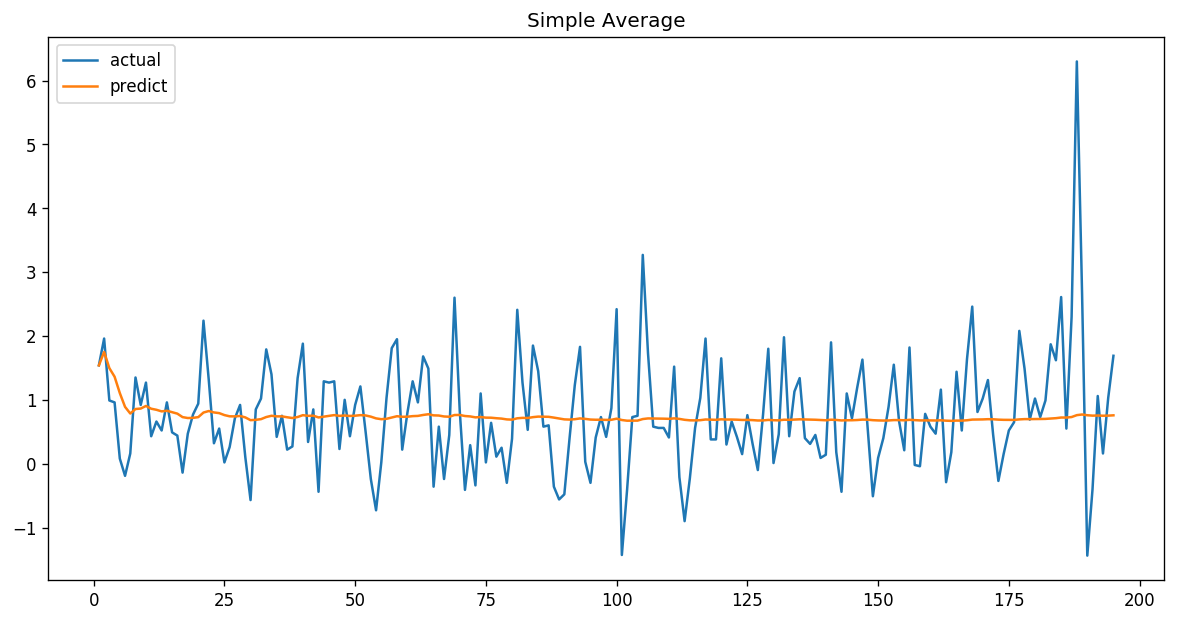

In [513]:
plt.figure(figsize=(12,6), dpi=120)
plt.plot(y_true, label="actual")
plt.plot(y_pred, label="predict")
plt.title("Simple Average")
plt.legend(loc='best')
plt.show()

### Single Moving Average

Smooths historical data by averaging the last several periods and projecting the last average value forward.

This method is best for volatile data with no trend or seasonality. It results in a straight, flat-line forecast.

$$
\begin{equation}
  \hat{y}_{t} = \frac{1}{m} \sum_{j=-k}^k y_{t+j}, \tag{6.1}
\end{equation}
$$

where;

* $m=2k+1$ is the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within $k$ periods of $t$.

It is shown as SMA(m) or MA(m) or $m-MA$ for $m$ rolling periods.

In [514]:
#Add new column by applying above model
rolling = 3
shift = rolling - 1
df_single_moving_average = pd.concat([df.CPI, df.CPI.rolling(rolling).mean()], axis=1)
#Skip first (shift) rows due to NaN forecast value
df_single_moving_average = df_single_moving_average.iloc[shift:]
#Rename columns
df_single_moving_average.columns = ['Actual', 'Predict']
y_true = df_single_moving_average['Actual']
y_pred = df_single_moving_average['Predict']
df_single_moving_average.head()

,Actual,Predict
3,0.99,1.496667
4,0.96,1.303333
5,0.08,0.676667
6,-0.19,0.283333
7,0.16,0.016667


In [515]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 0.523
RMSE: 0.723
ME: -0.002
MAE: 0.530
MPE: -0.300
MAPE: 1.972


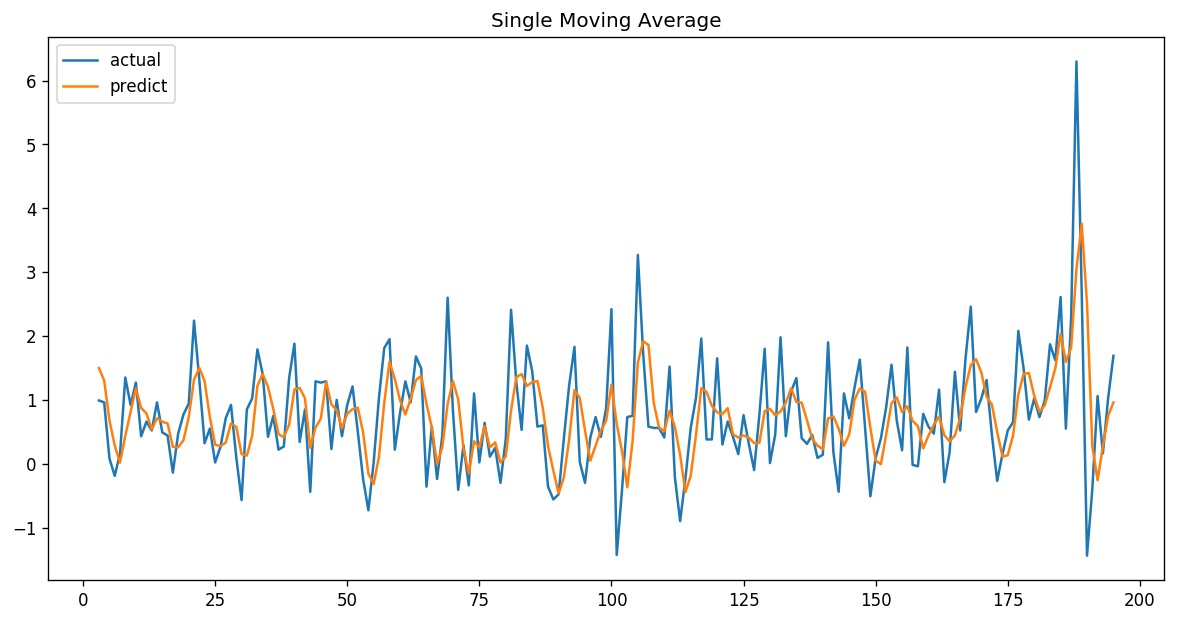

In [516]:
plt.figure(figsize=(12,6), dpi=120)
plt.plot(y_true, label="actual")
plt.plot(y_pred, label="predict")
plt.title("Single Moving Average")
plt.legend(loc='best')
plt.show()

### Double Moving Average

Applies the moving average technique twice, once to the original data and then to the resulting single moving average data. This method then uses both sets of smoothed data to project forward.

This method is best for historical data with a trend but no seasonality. It results in a straight, sloped-line forecast.

$$ a=2 \times SMA-DMA $$
$$ b=\frac{2}{N-1} (SMA-DMA) $$
$$ \hat{y}_{t+1} =a+b $$

It is shown as DMA(3x3) or MA(3x3) for 3 double rolling periods.

In [517]:
rolling_sma = 3
shifting_sma = rolling_sma - 1
df_sma = pd.concat([df.CPI, df.CPI.rolling(rolling_sma).mean()], axis=1)
df_sma = df_sma.iloc[shifting_sma:]
df_sma.columns = ['Actual', 'SMA']
#df_sma.head()

rolling_dma = 3
shifting_dma = rolling_dma - 1
df_dma = pd.concat([df_sma, df_sma['SMA'].rolling(rolling_dma).mean()], axis=1)
df_dma = df_dma.iloc[shifting_dma:]
df_dma.columns = ['Actual', 'SMA', 'DMA']
#df_dma.head()

df_dma_ab = pd.concat([df_dma, 2*df_sma['SMA']-df_dma['DMA'], (2/(rolling_sma-1))*(df_sma['SMA']-df_dma['DMA'])], axis=1)
df_dma_ab.columns = ['Actual', 'SMA', 'DMA', 'a', 'b']

df_dma_p = pd.concat([df_dma, 2*df_sma['SMA']-df_dma['DMA'], (2/(rolling_sma-1))*(df_sma['SMA']-df_dma['DMA']), (df_dma_ab['a']+df_dma_ab['b']).shift(1)], axis=1)
df_dma_p = df_dma_p.iloc[shifting_dma+1:]
df_dma_p.columns = ['Actual', 'SMA', 'DMA', 'a', 'b', 'Predict']

y_true = df_dma_p['Actual']
y_pred = df_dma_p['Predict']
df_dma_p.head()

,Actual,SMA,DMA,a,b,Predict
6,-0.19,0.283333,0.754444,-0.187778,-0.471111,-0.287778
7,0.16,0.016667,0.325556,-0.292222,-0.308889,-0.658889
8,1.35,0.440000,0.246667,0.633333,0.193333,-0.601111
9,0.92,0.810000,0.422222,1.197778,0.387778,0.826667
10,1.27,1.180000,0.810000,1.550000,0.370000,1.585556


In [518]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
me = mean_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mpe = mean_percentage_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('ME: %.3f' % me)
print('MAE: %.3f' % mae)
print('MPE: %.3f' % mpe)
print('MAPE: %.3f' % mape)

MSE: 1.811
RMSE: 1.346
ME: 0.015
MAE: 1.003
MPE: -0.374
MAPE: 3.872


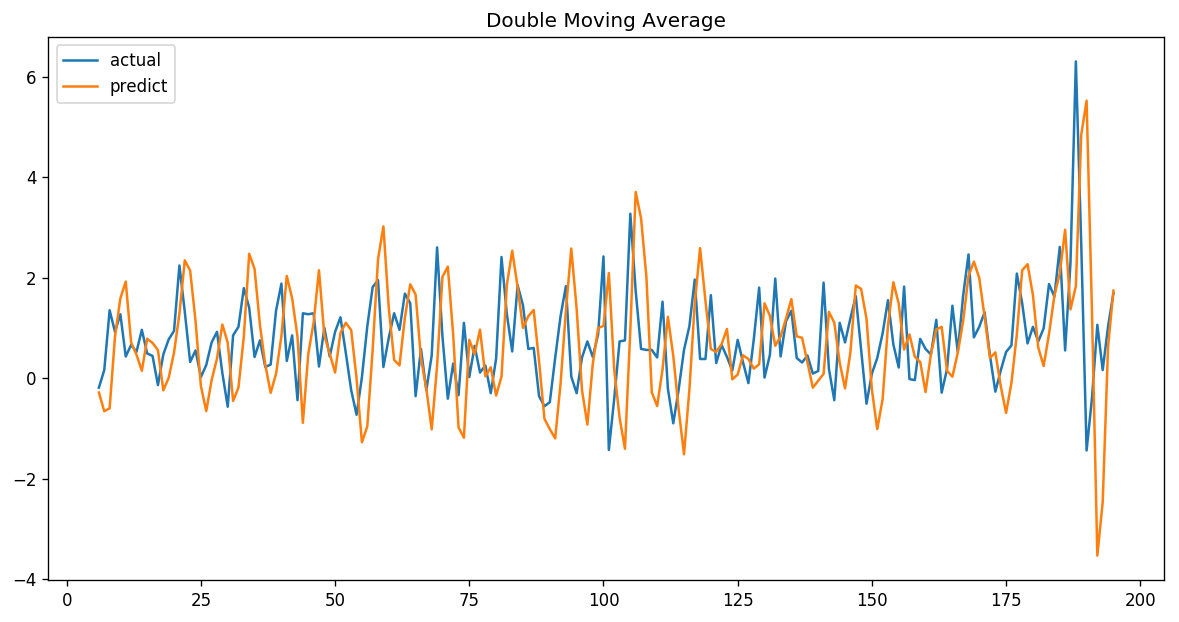

In [519]:
plt.figure(figsize=(12,6), dpi=120)
plt.plot(y_true, label="actual")
plt.plot(y_pred, label="predict")
plt.title("Double Moving Average")
plt.legend(loc='best')
plt.show()

## Smoothing Methods

Moving-average forecasting gives equal weights to the past values included in each average; exponential smoothing gives more weight to the recent observations and less to the older observations.

The predominant reason for using simple smoothing is that it requires a limited quantity of data and it is simpler than most other forecasting methods.

### Simple Exponential Smoothing

>When to use?

Few data points, Irregular data, No seasonality or trend. Its forecasts lag behind the actual data and it has no ability to adjust for any trend or seasonality in the data.

>Math behind

SES only has one component called *smoothing constant for the level*. It is a weighted average of the previous level and the current observation:

$$
\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t}\\
  \text{Level equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}
$$

where;

* $ \alpha $: Smoothing level ($ 0 \le \alpha \le 1$)

In practice, relatively small values of alpha ($\alpha$) generally work best when simple exponential smoothing is the most appropriate model.

* $\alpha=0$: the forecasts of all future values are equal to the average (or “mean”) of the historical data, which is called **Average method**.

* $\alpha=1$: simply set all forecasts to be the value of the last observation, which is called **Naive method** in statistics.


Here we run three variants of simple exponential smoothing:

1. In model1, we explicitly provide the model with the smoothing parameter $\alpha=0.2$

2. In model2, we choose an $\alpha=0.6$

3. In model3, we use the auto optimization that allow statsmodels to automatically find an optimized value for us. **This is the recommended approach.**

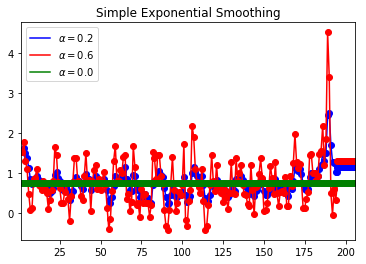

In [520]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

series = df.CPI

fit1 = SimpleExpSmoothing(series).fit(smoothing_level=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')

fit2 = SimpleExpSmoothing(series).fit(smoothing_level=0.6, optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')

fit3 = SimpleExpSmoothing(series).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.title('Simple Exponential Smoothing')
plt.show()

### Holt’s Linear Trend

>When to use? 

Trend in data, No seasonality.

>Math behind

The forecast is made of a level component and a trend component:

* Holt’s two-parameter exponential smoothing method (called Double Exponential Smoothing Holt) is the <mark>first extension of simple exponential smoothing</mark>
* With a trend in the data the simple smoothing model will have large errors. So, it adds a growth factor (or trend factor) to the smoothing equation as a way of adjusting for the trend.

Three equations and two smoothing constants are used in the model.

$$
\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}
$$

where;
* $b$: Slope (trend) estimate
* $\beta^*$: Smoothing slope (trend) ($ 0 \le \beta \le 1$)
* $h$: Number of periods in the forecast lead period


Here we run three variants of Holt’s method:

1. In model1, we explicitly provide the model with the smoothing parameter $\alpha=0.8$, $\beta=0.2$

2. In model2, we use an exponential model rather than a Holt’s additive model (which is default).

3. In model3, we use a damped version of the Holt’s additive model but allow the dampening parameter $\phi$ to be optimized while fixing the values for $\alpha=0.8$, $\beta=0.2$

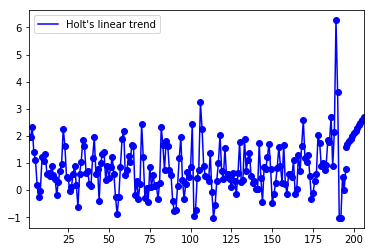

In [521]:
from statsmodels.tsa.holtwinters import Holt

series = df.CPI

fit1 = Holt(series).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fcast1.plot(color='blue', marker="o", legend=True)
fit1.fittedvalues.plot(marker="o", color='blue')

plt.show()

### Holt-Winters Additive/Multiplicative Seasonal

This method is used for data that exhibit both trend and seasonality. Seasonality is a common characteristic of time series. It can appear in two forms: *additive* and *multiplicative*.

> **Additive model**

1. Data is represented in terms of addition of seasonality, trend-cyclical and residual components. $y_{t} = S_{t} + T_{t} + R_t$

2. Used where change is measured in absolute quantity

3. Data is modeled as-is

$$
\begin{align*}
  \text{Forecast equation} && \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \text{Level equation} && \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation} && b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  \text{Seasonality equation} && s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}
$$

> **Multiplicative model**

1. Data is represented in terms of multiplication of seasonality, trend-cyclical and residual components. $y_{t} = S_{t} \times T_{t} \times R_t$

2. Used where change is measured in percent(%) change

3. Data is modeled just as additive but after taking logarithm (with base as natural or base 10)

$$
\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= (\ell_{t} + hb_{t})s_{t+h-m(k+1)} \\
  \text{Level equation} && \ell_{t} &= \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation} && b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1} \\
  \text{Seasonality equation} && s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}
\end{align*}
$$

where;

* $\gamma$: Smoothing constant for the seasonality estimate ($ 0 \le \gamma \le 1$)
* $m$: Number of periods in the seasonal cycle

A two-way classification of exponential smoothing methods.

|                      | N (None) | A (Additive) | M (Multiplicative) |
|----------------------|----------|--------------|--------------------|
| N (None)             | (N,N)    | (N,A)        | (N,M)              |
| A (Additive)         | (A,N)    | (A,A)        | (A,M)              |
| Ad (Additive damped) | (Ad,N)   | (Ad,A)       | (Ad,M)             |

| Short hand | Method                              |
|------------|-------------------------------------|
| (N,N)      | Simple exponential smoothing        |
| (A,N)      | Holt’s linear method                |
| (Ad,N)     | Additive damped trend method        |
| (A,A)      | Additive Holt-Winters’ method       |
| (A,M)      | Multiplicative Holt-Winters’ method |
| (Ad,M)     | Holt-Winters’ damped method         |

Here, we run full Holt-Winters’ method including a trend component and a seasonal component.

1. In fit1, we use additive trend, additive seasonal of period season_length=4

2. In fit2, we use additive trend, multiplicative seasonal of period season_length=4

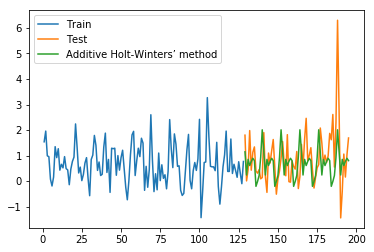

In [522]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_size = int(len(X) * 0.66)
train, test = df.CPI.iloc[:train_size], df.CPI.iloc[train_size:]
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Additive Holt-Winters’ method')
plt.legend(loc='best')
plt.show()

In [0]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing

#train_size = int(len(X) * 0.66)
#train, test = df.CPI.iloc[:train_size], df.CPI.iloc[train_size:]
#model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
#pred = model.predict(start=test.index[0], end=test.index[-1])

#plt.plot(train.index, train, label='Train')
#plt.plot(test.index, test, label='Test')
#plt.plot(pred.index, pred, label='Multiplicative Holt-Winters’ method')
#plt.legend(loc='best')
#plt.show()

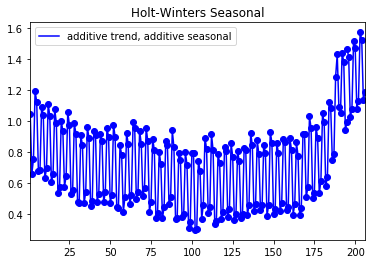

In [524]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series = df.CPI

fit1 = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=4).fit()
fcast1 = fit1.forecast(12).rename('additive trend, additive seasonal')
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')

#fit2 = ExponentialSmoothing(series, trend='add', seasonal='mul', seasonal_periods=4).fit()
#fcast2 = fit2.forecast(12).rename('additive trend, multiplicative seasonal')
#fcast2.plot(marker='o', color='red', legend=True)
#fit2.fittedvalues.plot(marker='o', color='red')

plt.title('Holt-Winters Seasonal')
plt.show()

# Regression Models

## Bivariate (Simple) Regression Analysis

Linear regression is a statistical approach for modelling relationship between a dependent (explanatory) variable (**response**) with a given set of independent (exploratory) variables (**features**).

Bivariate regression analysis (also called simple linear least-squares regression) is an approach for predicting a response using a single feature.

$$y = \beta _0 + \beta_1 x +\epsilon \quad \text{(true)}$$

$$\hat{y} = b_0 + b_1 x \quad \text{(prediction)}$$

$$ e = y - \hat{y} \quad \text{(residuals)}$$

$$ SST = \sum (y - \bar{y})^2 \quad \text{(Sum of Squares Total, SST)} $$

$$ SSE = \text{Minimize} 􏰘\sum e^2 = \sum (y - \hat{y})^2 \quad \text{(OLS or Sum of the Squared Error)} $$

$$ b_1 = \frac{\sum xy - n \bar{x} \bar{y}}{\sum x^2 - n \bar{x}^2} $$

$$ b_0 = \bar{y} - b_1 \bar{x} $$

$$ SSR = \sum (\hat{y} - \bar{y})^2 \quad \text{(Sum of Squares due to Regression, SSR)} $$

$$ SST = SSR+SSE $$

$$ r^2 = \frac{SSR}{SST} = 1-\frac{SSE}{SST} $$

$$ s^2 = MSE = \frac{SSE}{n-k-1} = \frac{\sum e^2}{n-2} $$

$$ s = \sqrt{\frac{\sum e^2}{n-2}}, s_{b_0} = s \sqrt{\frac{\sum X^2}{n \sum x^2}}, s_{b_1} = s \sqrt{\frac{1}{\sum x^2}} $$

$$ MSR = \frac{SSR}{k}$$

$$ F = \frac{MSR}{MSE} $$

> t-test
$$
\begin{aligned}
H_0&: \beta_0 = 0 \quad \text{test ediyoruz} \\
H_1&: \beta_0 \ne 0 \\
t_{b_0}&=\frac{b_0-\beta_0}{s_{b_0}} \\
H_0&: \beta_1 = 0 \quad \text{test ediyoruz} \\
H_1&: \beta_1 \ne 0 \\
t_{b_1}&=\frac{b_1-\beta_1}{s_{b_1}} \\
\end{aligned}
$$

where;

* $\beta_0$: intercept
* $\beta_1$: slope
* $x$: X or T (time index) as independent variable. T is usually set equal to 1 for the first observation and increased by 1 for each subsequent observation.
* $\hat{y}$: predicted response
* $y$: real or true response
* $e$: residuals or errors
* OLS: The ordinary least-squares method seeks to find estimates of the slope and intercept parameters that minimize the sum of squared residuals
* SSR: Explained Variability
* SSE: Unexplained Variability
* $r^2$: The coefficient of determination is the proportion of the variability in Y that is explained by the regression equation.
* $r$: The correlation coefficient measures the strength of the linear relationship.
* $s^2$: The mean squared error (MSE) is the estimate of the error variance of the regression equation.
* $n$: number of observations in the sample
* $k$: number of independent variables
* $s$: The standard deviation of the regression is used in many statistical tests about the regression model. Regression standard error.
* $F$: An F-test is used to statistically test the null hypothesis that there is no linear relationship between the X and Y variables (i.e. β  = 0). If the significance level for the F test is low, we reject Ho and conclude there is a linear relationship.

Good regression models have significant F-test and high $r^2$ values.

ANOVA Table

When developing a regression model, an ANOVA table is computing by most statistical software. The general form of the ANOVA table is helpful for understanding the interrelatedness of error terms.

|            | DF    | SS  | MS  | F       | Significance |
|------------|-------|-----|-----|---------|--------------|
| Regression | k     | SSR | MSR | MSR/MSE | P-value      |
| Residual   | n-k-1 | SSE | MSE |         |              |
| Total      | n-k   | SST |     |         |              |

> Process

* Thoroughly review the data
* Select the type of regression model
* Estimate the regression coefficients ($b_0$ and $b_1$, in simple bivariate regression models)
* Use a holdout period for evaluation. If you have 10 years of quarterly data (n=40), you might use 9 years of data (n=36) to estimate the regression coefficients
* Determine how well the model "fits" the data (often called an *in-sample* evaluation)

In [525]:
import numpy as np
from sklearn.linear_model import LinearRegression

df_bra = df.dropna()
x = df_bra.M1.values.reshape((-1, 1))
y = df_bra.CPI

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

x_new = np.arange(5).reshape((-1, 1))
y_new = model.predict(x_new)
print(y_new)

coefficient of determination: 0.08476893576548672
intercept: 0.19961833074804575
slope: [0.0058942]
predicted response:
[0.24705297 0.24961831 0.2560578  0.26487491 0.27054224 0.27657784
 0.28149389 0.28249868 0.29036035 0.29814287 0.30533485 0.31600623
 0.32238576 0.34455341 0.33666563 0.33792398 0.33691831 0.34305988
 0.34578819 0.34961317 0.35928159 0.36391042 0.36771053 0.36997526
 0.38313717 0.38618158 0.39388471 0.41512538 0.42305001 0.43149327
 0.4417968  0.4604623  0.47811347 0.49443744 0.51879261 0.51821722
 0.51503365 0.52891371 0.5381053  0.55206028 0.57378793 0.6034434
 0.62783051 0.65129436 0.66737402 0.67220991 0.70089785 0.71633893
 0.75113319 0.78647597 0.8226454  0.83208732 0.85882398 0.88223985
 0.89749226 0.96068451 1.01454449 1.05472464 1.07750099 1.11163545
 1.12783741 1.22737034 1.28270269 1.23377261]
[0.19961833 0.20551253 0.21140672 0.21730092 0.22319511]


A scatter plot of above "Actual" dataset and "Predict" (Regression Line) looks like

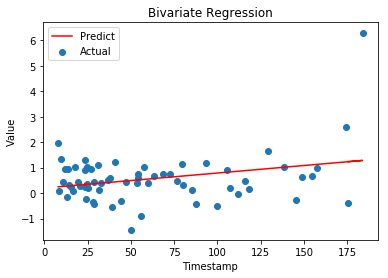

In [526]:
import matplotlib.pyplot as plt
plt.scatter(x, y, label='Actual')
plt.plot(x, y_pred, color = "r", label='Predict') 
plt.title('Bivariate Regression')
plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

Now, the task is to find a line which fits best in above scatter plot so that we can predict the response for any new feature values. (i.e a value of x not present in dataset)

This line is called regression line. The equation of regression line is, for this example, represented as:

In [527]:
print("y = {} + {} [X]" . format(model.intercept_, model.coef_)) 

y = 0.19961833074804575 + [0.0058942] [X]


> OLS, Ordinary Least Square

In [528]:
import statsmodels.api as sm

X = df_bra.M1 ## X usually means our input variables (or independent variables)
y = df_bra.CPI ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     5.742
Date:                Fri, 17 May 2019   Prob (F-statistic):             0.0196
Time:                        17:22:02   Log-Likelihood:                -86.831
No. Observations:                  64   AIC:                             177.7
Df Residuals:                      62   BIC:                             182.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1996      0.193      1.032      0.3

> Interpreting the Regression Results

Several important components are highlighted within the results:

* **Adjusted R-squared** reflects the fit of the model. R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.

* **const coefficient** is the Y-intercept.

* **x1 coefficient** represents the change in the output Y due to a change of one unit in the x1 (everything else held constant). In this case x1 is Actual CPI value.

* **std err** reflects the level of accuracy of the coefficients. The lower it is, the higher is the level of accuracy

* **P >|t|** is the p-value. A p-value of less than 0.05 is considered to be statistically significant

* **Confidence Interval** represents the range in which our coefficients are likely to fall (with a likelihood of 95%)

## Multivariate Regression Analysis

The following Python code includes an example of Multivariate Regression Analysis, where the input variables are:

1. M1
2. M3
3. GDP
4. FX

These independent variables are used in the prediction of the dependent variable of **CPI**.

In [529]:
df.head()

,Date,CPI,M1,M3,USDTRY,QGDP
1,2003-02-01,1.54,7.925606,12.84485,1.5970,NaN
2,2003-03-01,1.96,8.047686,12.94970,1.7155,1.448892
3,2003-04-01,0.99,7.998527,12.86963,1.5657,NaN
4,2003-05-01,0.96,8.018188,12.73953,1.4290,NaN
5,2003-06-01,0.08,8.482919,12.74100,1.4200,0.362453


In [530]:
df_mra = df.set_index('Date')

df_mra = pd.concat([df_mra.CPI.resample('Q').mean(), df_mra.M1.resample('Q').sum(), df_mra.M3.resample('Q').sum(), df_mra.USDTRY.resample('Q').ffill(), df_mra.QGDP.resample('Q').mean()], axis=1)
df_mra = df_mra.dropna()
df_mra.head()

,CPI,M1,M3,USDTRY,QGDP
Date,,,,,
2003-03-31,1.750000,15.973292,25.79455,1.7155,1.448892
2003-06-30,0.676667,24.499634,38.35016,1.4200,0.362453
2003-09-30,0.440000,27.774865,38.95456,1.3898,2.892060
2003-12-31,0.873333,31.949660,41.89267,1.4026,2.018129
2004-03-31,0.713333,36.438980,44.52600,1.3135,4.008951


In [531]:
import statsmodels.api as sm

X = df_mra[['M1','M3','USDTRY','QGDP']]
Y = df_mra['CPI']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     6.540
Date:                Fri, 17 May 2019   Prob (F-statistic):           0.000200
Time:                        17:22:02   Log-Likelihood:                -38.301
No. Observations:                  64   AIC:                             86.60
Df Residuals:                      59   BIC:                             97.40
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2120      0.317     -0.669      0.5

# References

* Business Forecasting, Eighth Edition, John E. Hanke and Dean W. Wichern. ISBN 9780131228566, Pearson International Edition
* [Forecasting: Principles and Practice](https://otexts.com/fpp2/), Rob J Hyndman and George Athanasopoulos, Monash University, Australia
* [How to Grid Search Triple Exponential Smoothing for Time Series Forecasting in Python](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/)